<a href="https://colab.research.google.com/github/droyktton/ALM-pbc-ground-state/blob/main/NuevoALM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sumary of Results

* Exact parallel algorithm for the ground state (more efficient than Dijkstra)

* Spectral exponent $\zeta_s$ vs anharmonicity index $n$, $\zeta_s - \zeta$ is not constant, but has little non-trivial variation.

* Finite size scaling confirms anomalous scaling.

#Exact Numerical Construction of the Ground State (1D)

We consider a one–dimensional elastic interface with quenched disorder,
described by the Hamiltonian
\begin{equation}
\mathcal H[u] =
\sum_{i=0}^{L-1}
\left[
\frac{c}{2}\,(u_{i+1}-u_i)^2
+ \frac{1}{2n}\,|u_{i+1}-u_i|^{2n}
- f_i\,u_i
\right],
\qquad n \ge 1 ,
\end{equation}
with periodic boundary conditions. The disorder forces $f_i$
 are
independent Gaussian variables,
\begin{equation}
f_i \sim \mathcal N(0,\Delta).
\end{equation}

Define the local slope
\begin{equation}
s_i = u_{i+1} - u_i .
\end{equation}

## Integrated equilibrium condition

At zero temperature, minimization of $\mathcal H$ yields
\begin{equation}
c\, s_i + |s_i|^{2n-1}\,\mathrm{sign}(s_i) = \sigma_i ,
\end{equation}
where the stress field $\sigma_i$ is the cumulative sum of the disorder,
\begin{equation}
\sigma_i = \sum_{j=0}^{i-1} f_j + C .
\end{equation}
The constant $C$ is a Lagrange multiplier enforcing periodicity.

## Local constitutive inversion

For each site $i$, the slope is obtained by inverting the constitutive law,
\begin{equation}
s_i = g(\sigma_i),
\end{equation}
where $g$ is the unique solution of
\begin{equation}
c\, s + |s|^{2n-1}\,\mathrm{sign}(s) = \sigma .
\end{equation}

*Pure nonlinear elasticity ($c=0$)*

The inversion is analytic:
\begin{equation}
s_i =
\mathrm{sign}(\sigma_i)\,
|\sigma_i|^{\frac{1}{2n-1}} .
\end{equation}

*Harmonic + nonlinear elasticity ($c>0$)*

The inversion is performed locally by a scalar root solve; uniqueness and
stability are guaranteed by convexity.

## Global constraint

Periodic boundary conditions require zero total slope,
\begin{equation}
\sum_{i=0}^{L-1} s_i(C) = 0 .
\end{equation}
Since $s_i(C)$ is a strictly monotonic function of $C$, this condition is
enforced by a one–dimensional root finding procedure.

## Reconstruction of the displacement

Once $C$ is fixed, the displacement field is reconstructed by summation,
\begin{equation}
u_{i+1} = u_i + s_i ,
\end{equation}
with an arbitrary additive constant (e.g. $\sum_i u_i = 0$).

## Properties

* The algorithm yields the exact $T=0$ ground state.
* Computational cost scales linearly with system size $L$.
* Disorder enters only through a prefix sum.
* High-dimensional minimization reduces to a scalar constraint.


# CUDA code

In [ ]:
%%writefile alm.cu

#include <thrust/device_vector.h>
#include <thrust/host_vector.h>
#include <thrust/transform.h>
#include <thrust/transform_reduce.h>
#include <thrust/scan.h>
#include <thrust/reduce.h>
#include <thrust/random.h>
#include <thrust/functional.h>
#include <cmath>
#include <iostream>
#include <fstream>

#ifndef ANHN
#define ANHN 2
#endif

#ifndef SIZEL
#define SIZEL 1024
#endif

typedef double real;

const int L = SIZEL;
const real Delta = 1.0f;
const real n = ANHN;
const real c = 0.0f;   // set c=0 for closed form

// -----------------------------
// Gaussian disorder
// -----------------------------
struct gaussian_rng {
    unsigned int seed;
    __host__ __device__
    real operator()(unsigned int i) const {
        thrust::default_random_engine rng(seed);
        rng.discard(i);
        thrust::normal_distribution<real> dist(0.0f, sqrtf(Delta));
        return dist(rng);
    }
};

// -----------------------------
// Constitutive law
// -----------------------------
struct slope_functor {
    real C;

    __host__ __device__
    real operator()(real F) const {
        real sigma = F + C;

        if (c == 0.0f) {
            return copysignf(powf(fabsf(sigma), 1.0f/(2.0f*n-1.0f)), sigma);
        }

        // Newton iteration (few steps, monotonic)
        real s = sigma / (c + 1.0f);
        for (int k=0; k<8; k++) {
            real g  = c*s + copysignf(powf(fabsf(s),2*n-1), s) - sigma;
            real gp = c + (2*n-1)*powf(fabsf(s),2*n-2);
            s -= g/gp;
        }
        return s;
    }
};


int main(int argc, char **argv) {

    unsigned seed = 1;
    if (argc > 1) {
        seed = atoi(argv[1]);
    }

    // -----------------------------
    // Disorder
    // -----------------------------
    thrust::device_vector<real> f(L);
    thrust::transform(
        thrust::counting_iterator<unsigned int>(0),
        thrust::counting_iterator<unsigned int>(L),
        f.begin(),
        gaussian_rng{seed}
    );

    // -----------------------------
    // Prefix sum: cumulative force
    // -----------------------------
    thrust::device_vector<real> F(L);
    thrust::exclusive_scan(f.begin(), f.end(), F.begin());

    // -----------------------------
    // Find C by scalar root-finding
    // -----------------------------
    real C_lo = -50.0f, C_hi = 50.0f, C = 0.0f;

    for (int it=0; it<40; it++) {
        C = 0.5f*(C_lo + C_hi);

        real S = thrust::transform_reduce(
            F.begin(), F.end(),
            slope_functor{C},
            0.0f,
            thrust::plus<real>()
        );

        if (S > 0) C_hi = C;
        else       C_lo = C;
    }

    std::cout << "C = " << C << std::endl;

    // -----------------------------
    // Final slopes
    // -----------------------------
    thrust::device_vector<real> s(L);
    thrust::transform(F.begin(), F.end(), s.begin(), slope_functor{C});

    // -----------------------------
    // Reconstruct u
    // -----------------------------
    thrust::device_vector<real> u(L);
    thrust::exclusive_scan(s.begin(), s.end(), u.begin());

    real mean_u = thrust::reduce(u.begin(), u.end(), 0.0f) / L;
    thrust::transform(u.begin(), u.end(), u.begin(),
                      [=] __host__ __device__ (real x) { return x - mean_u; });

    real mean_s = thrust::reduce(s.begin(), s.end(), 0.0f) / L;
    std::cout << "Check periodicity (sum s): " << mean_s << std::endl;

    // Print first 10 elements of u
    thrust::host_vector<real> h_u_head(10);
    thrust::copy_n(u.begin(), 10, h_u_head.begin());

    std::cout << "First 10 elements of u: [";
    for (int i = 0; i < 10; ++i) {
        std::cout << h_u_head[i] << (i == 9 ? "" : ", ");
    }
    std::cout << "]" << std::endl;

    std::ofstream fout("u.txt");
    for (int i = 0; i < L; ++i) {
        fout << u[i] << std::endl;
    }

    std::cout << "Done." << std::endl;

    std::cout << "n=" << n << ", c=" << c << std::endl;
    std::cout << "L=" << L << ", Delta=" << Delta << std::endl;
    std::cout << "seed=" << seed << std::endl;

    return 0;
}

Overwriting alm.cu


In [ ]:
!nvcc  -arch=sm_75 alm.cu --extended-lambda -o a.out -DANHN=2 -DSIZEL=1024

A small test

In [ ]:
!./a.out 2236

C = -6.92505
Check periodicity (sum s): -1.11759e-07
First 10 elements of u: [23.1272, 21.2212, 19.175, 17.0436, 14.9358, 12.8558, 10.7464, 8.56086, 6.37289, 4.30363]
Done.
n=2, c=0
L=512, Delta=1
seed=2236


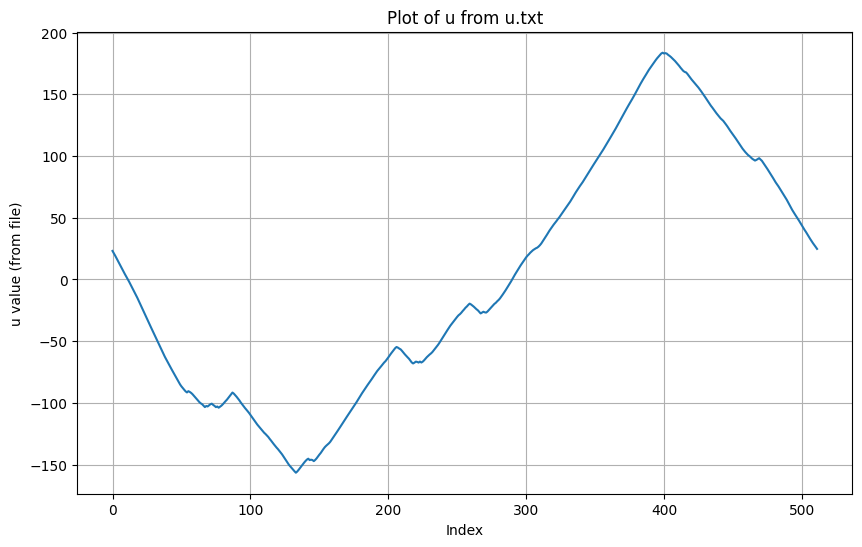

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Read u.txt
u_from_file = np.loadtxt('u.txt')

# Plot u_from_file
plt.figure(figsize=(10, 6))
plt.plot(u_from_file)
plt.xlabel('Index')
plt.ylabel('u value (from file)')
plt.title('Plot of u from u.txt')
plt.grid(True)
plt.show()

# Spectral exponent vs anharmonicity exponent $n$

In [ ]:
%%bash
rm u_*.txt
for((i=0;i<50;i++))
do
  ./a.out $i
  mv u.txt u_$i.txt
done

C = 3.59396
Check periodicity (sum s): 1.86265e-08
First 10 elements of u: [-230.448, -228.916, -229.703, -230.932, -232.102, -232.818, -231.677, -230.831, -229.967, -229.24]
Done.
n=2, c=0
L=1024, Delta=1
seed=0
C = 3.59396
Check periodicity (sum s): 1.86265e-08
First 10 elements of u: [-230.448, -228.916, -229.703, -230.932, -232.102, -232.818, -231.677, -230.831, -229.967, -229.24]
Done.
n=2, c=0
L=1024, Delta=1
seed=1
C = 5.99453
Check periodicity (sum s): 3.8743e-07
First 10 elements of u: [138.165, 139.982, 141.258, 142.298, 142.962, 143.986, 145.361, 146.679, 147.42, 148.494]
Done.
n=2, c=0
L=1024, Delta=1
seed=2
C = -23.9417
Check periodicity (sum s): -2.45869e-07
First 10 elements of u: [171.629, 168.747, 165.719, 162.668, 159.647, 156.643, 153.688, 150.74, 147.796, 144.819]
Done.
n=2, c=0
L=1024, Delta=1
seed=3
C = -14.3706
Check periodicity (sum s): -1.86265e-08
First 10 elements of u: [396.449, 394.018, 391.392, 388.745, 386.088, 383.438, 380.844, 378.284, 375.648, 373.023]

<>:68: SyntaxWarning: invalid escape sequence '\p'
<>:68: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-1071353500.py:68: SyntaxWarning: invalid escape sequence '\p'
  label=f'Power Law Fit: $S(q) \propto 1/q^{{1+2*{zeta:.2f}}}$')


Found 50 configurations.
Power law fit for q < 0.05: S(q) = 1.03e-01 * q^{-3.80}
zeta= 1.401787399782476


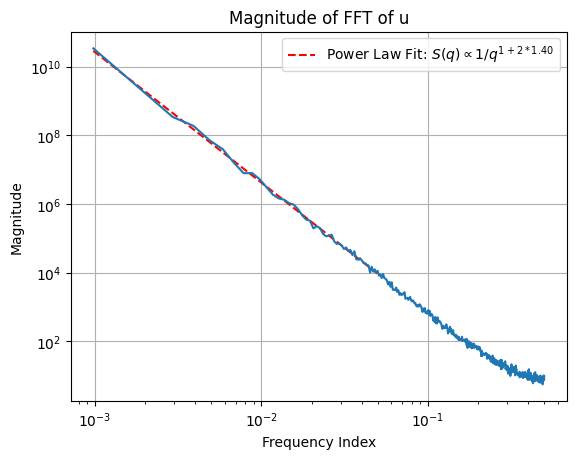

np.float64(1.401787399782476)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import glob

def plot_Sq(name):
  # Get all u_i.txt files
  u_files = sorted(glob.glob('u_*.txt'))
  num_configs = len(u_files)

  if num_configs == 0:
      print("No u_*.txt files found. Please make sure the bash script generated them.")
  else:
      print(f"Found {num_configs} configurations.")

      # Initialize an array to store the sum of |FFT(u)|^2
      L_u = np.loadtxt(u_files[0]).shape[0]
      sum_sq_magnitudes = np.zeros(L_u)

      for i, u_file in enumerate(u_files):
          u = np.loadtxt(u_file)

          # Subtract the mean from u before computing FFT
          u_mean_subtracted = u - np.mean(u)

          # Compute FFT of u
          fft_u = np.fft.fft(u_mean_subtracted)

          # Calculate squared magnitude: |FFT(u)|^2
          sq_magnitude = np.abs(fft_u)**2

          # Accumulate for averaging
          sum_sq_magnitudes += sq_magnitude

      # Average the squared magnitudes to get S(q)
      averaged_sq = sum_sq_magnitudes / num_configs
      with open(name, "w") as f:
        for sqdata in averaged_sq:
          print(sqdata, file=f)

      # Generate wave numbers q
      q = np.fft.fftfreq(L_u, d=1) # d=1 assumes unit spacing, 2*pi for angular frequency

      qpos = q[q>0]
      sqpos = averaged_sq[q>0]

      # Filter data for q < 0.05
      fit_indices = qpos < 0.05
      q_fit = qpos[fit_indices]
      sq_fit = sqpos[fit_indices]

      if len(q_fit) > 1:
          # Log-transform the data
          log_q = np.log(q_fit)
          log_sq = np.log(sq_fit)

          # Perform linear regression
          coeffs = np.polyfit(log_q, log_sq, 1) # 1 for linear fit
          log_A = coeffs[1] # Intercept
          B = coeffs[0]     # Slope (power law exponent)
          A = np.exp(log_A) # Convert intercept back to A

          # Generate the fit line for plotting
          q_fit_line = np.linspace(q_fit.min(), q_fit.max(), 100)
          sq_fit_line = A * q_fit_line**B

          zeta=-(B+1)/2
          plt.plot(q_fit_line, sq_fit_line, color='red', linestyle='--',
                  label=f'Power Law Fit: $S(q) \propto 1/q^{{1+2*{zeta:.2f}}}$')
          print(f"Power law fit for q < 0.05: S(q) = {A:.2e} * q^{{{B:.2f}}}")
          print("zeta=",zeta)

      plt.plot(qpos, sqpos)
      #plt.loglog(qpos, 1./qpos**(1+2*1.39))
      plt.xlabel('Frequency Index')
      plt.ylabel('Magnitude')
      plt.title('Magnitude of FFT of u')
      plt.loglog()
      plt.legend()
      plt.grid(True)
      plt.show()

      return zeta

plot_Sq('Sq.txt')



Found 50 configurations.
Power law fit for q < 0.05: S(q) = 1.03e-01 * q^{-3.80}
zeta= 1.401787399782476


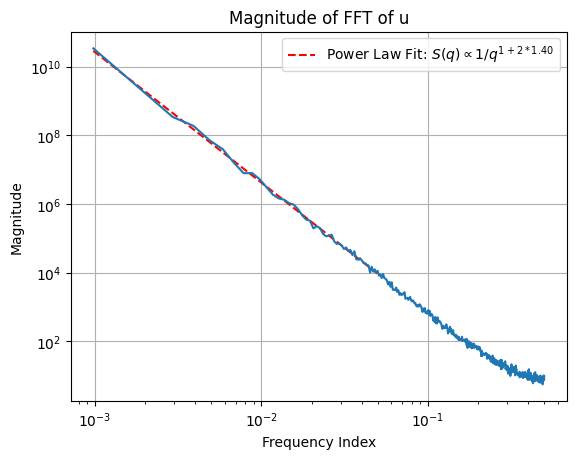

n=2, zeta=1.401787399782476
Found 50 configurations.
Power law fit for q < 0.05: S(q) = 1.07e-01 * q^{-3.69}
zeta= 1.3462617890788482


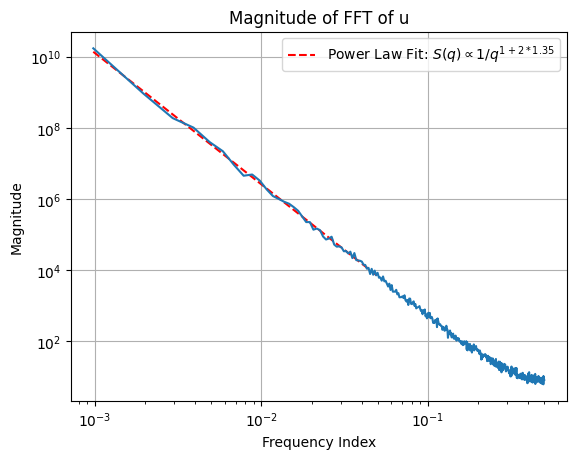

n=3, zeta=1.3462617890788482
Found 50 configurations.
Power law fit for q < 0.05: S(q) = 1.14e-01 * q^{-3.64}
zeta= 1.3188543603483125


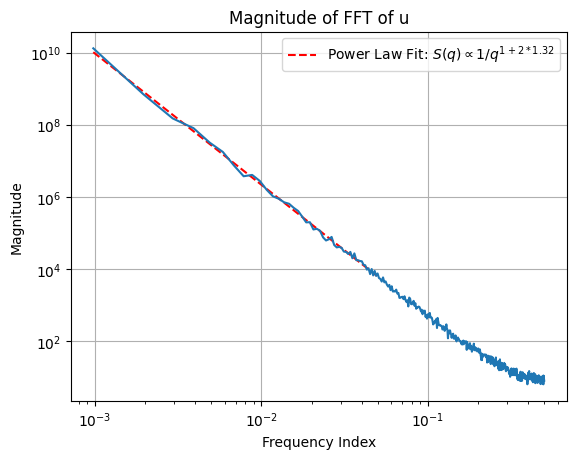

n=4, zeta=1.3188543603483125
Found 50 configurations.
Power law fit for q < 0.05: S(q) = 1.21e-01 * q^{-3.61}
zeta= 1.3027990261094047


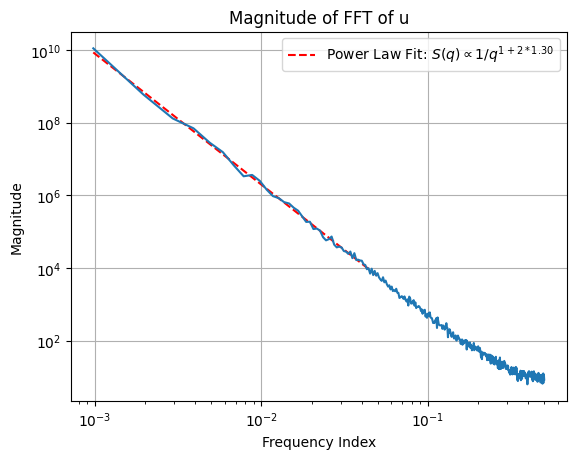

n=5, zeta=1.3027990261094047
Found 50 configurations.
Power law fit for q < 0.05: S(q) = 1.26e-01 * q^{-3.58}
zeta= 1.2917187866421733


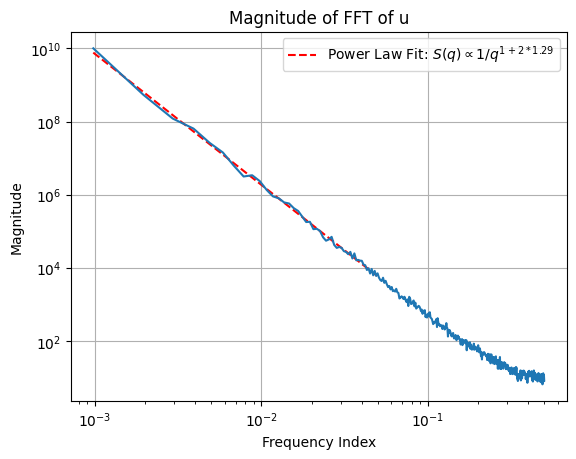

n=6, zeta=1.2917187866421733
Found 50 configurations.
Power law fit for q < 0.05: S(q) = 1.30e-01 * q^{-3.57}
zeta= 1.2840013007504583


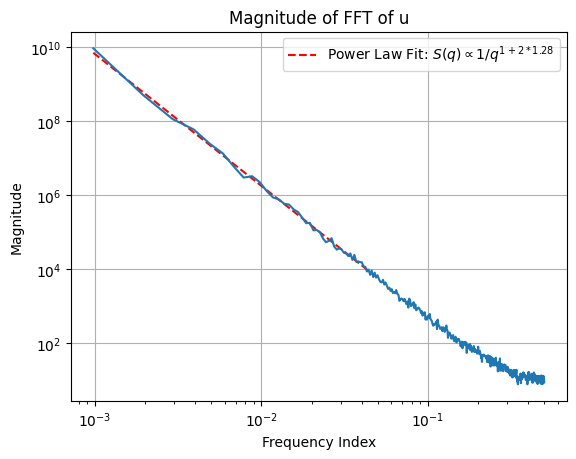

n=7, zeta=1.2840013007504583
Found 50 configurations.
Power law fit for q < 0.05: S(q) = 1.34e-01 * q^{-3.56}
zeta= 1.2778362133155647


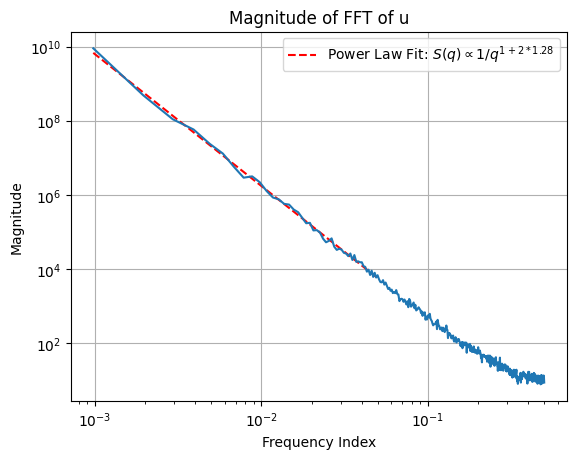

n=8, zeta=1.2778362133155647
Found 50 configurations.
Power law fit for q < 0.05: S(q) = 1.37e-01 * q^{-3.55}
zeta= 1.2731385604375474


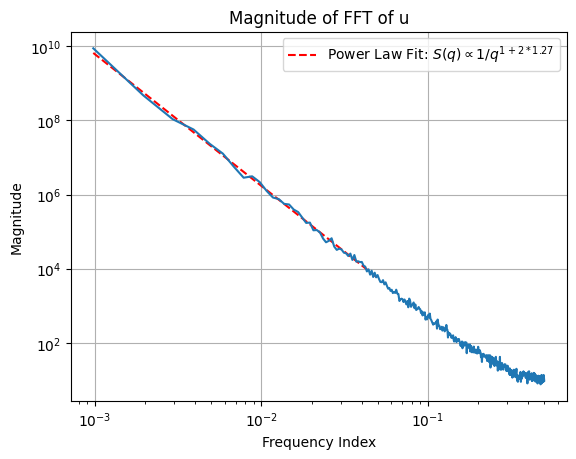

n=9, zeta=1.2731385604375474
Found 50 configurations.
Power law fit for q < 0.05: S(q) = 1.39e-01 * q^{-3.54}
zeta= 1.2694790488440233


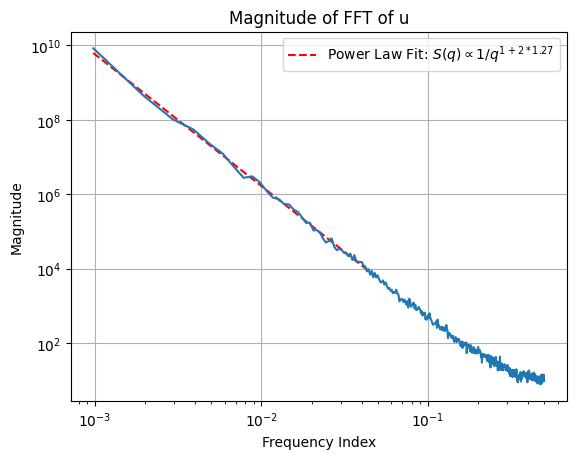

n=10, zeta=1.2694790488440233
Found 50 configurations.
Power law fit for q < 0.05: S(q) = 1.41e-01 * q^{-3.53}
zeta= 1.266553112755285


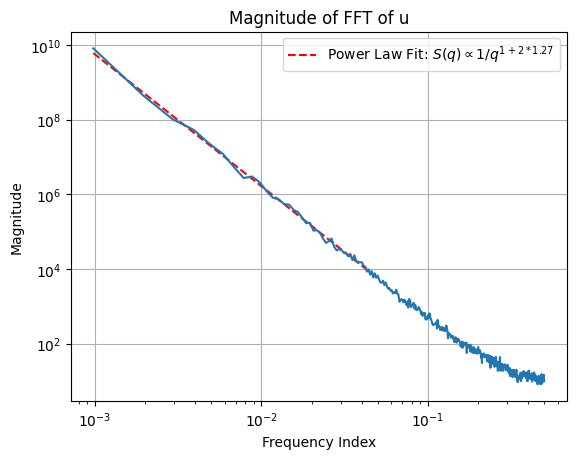

n=11, zeta=1.266553112755285
Found 50 configurations.
Power law fit for q < 0.05: S(q) = 1.43e-01 * q^{-3.53}
zeta= 1.2636553069235419


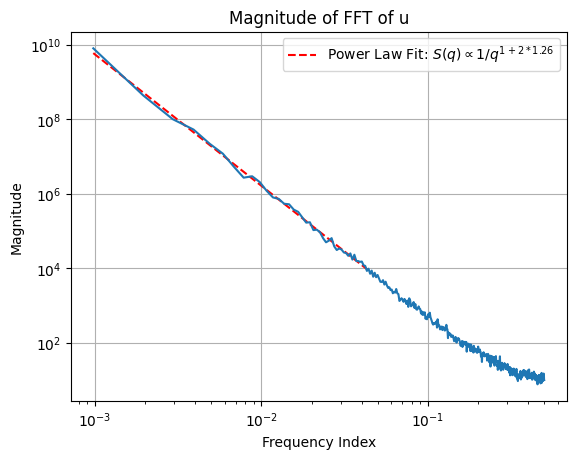

n=12, zeta=1.2636553069235419
Found 50 configurations.
Power law fit for q < 0.05: S(q) = 1.45e-01 * q^{-3.52}
zeta= 1.2614160606822133


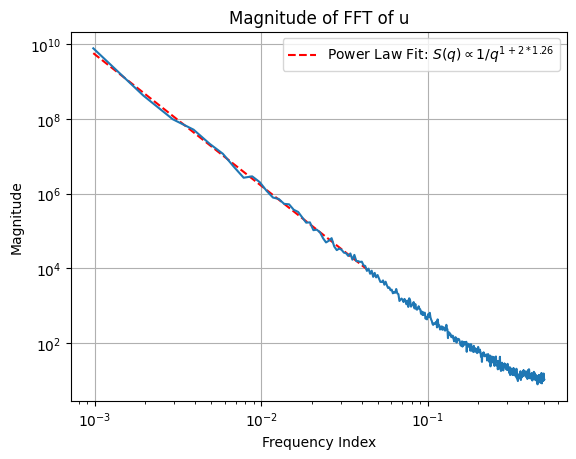

n=13, zeta=1.2614160606822133
Found 50 configurations.
Power law fit for q < 0.05: S(q) = 1.46e-01 * q^{-3.52}
zeta= 1.259703506528226


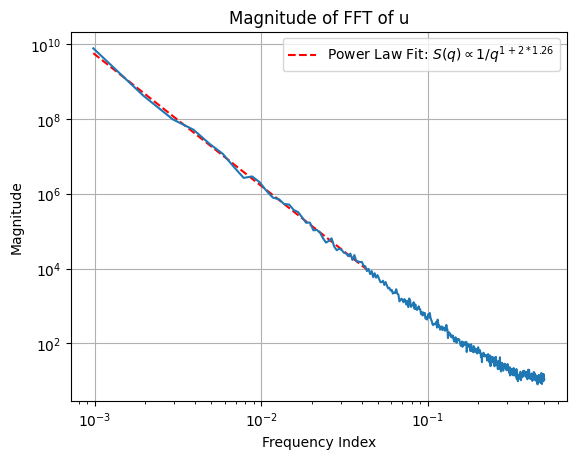

n=14, zeta=1.259703506528226
Found 50 configurations.
Power law fit for q < 0.05: S(q) = 1.47e-01 * q^{-3.52}
zeta= 1.2579760724196192


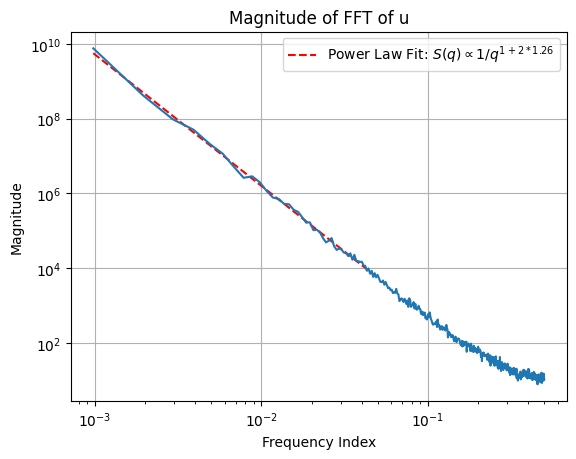

n=15, zeta=1.2579760724196192
Found 50 configurations.
Power law fit for q < 0.05: S(q) = 1.48e-01 * q^{-3.51}
zeta= 1.256664584174856


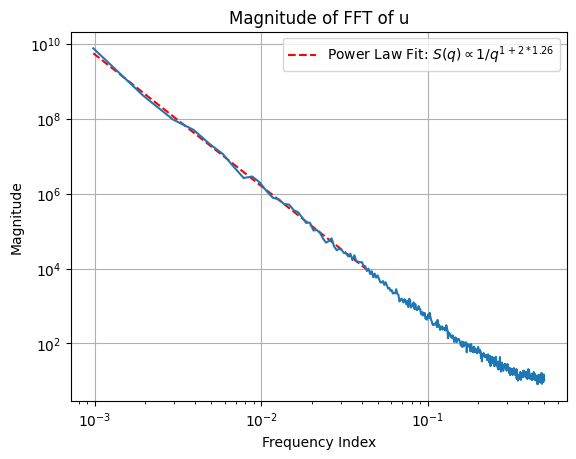

n=16, zeta=1.256664584174856
Found 50 configurations.
Power law fit for q < 0.05: S(q) = 1.49e-01 * q^{-3.51}
zeta= 1.255589810301991


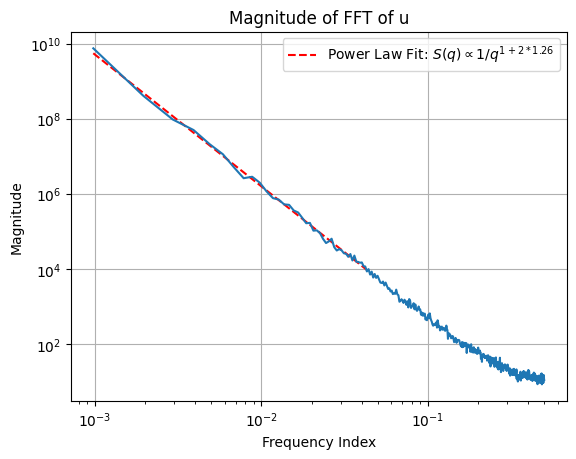

n=17, zeta=1.255589810301991
Found 50 configurations.
Power law fit for q < 0.05: S(q) = 1.50e-01 * q^{-3.51}
zeta= 1.2546139358827717


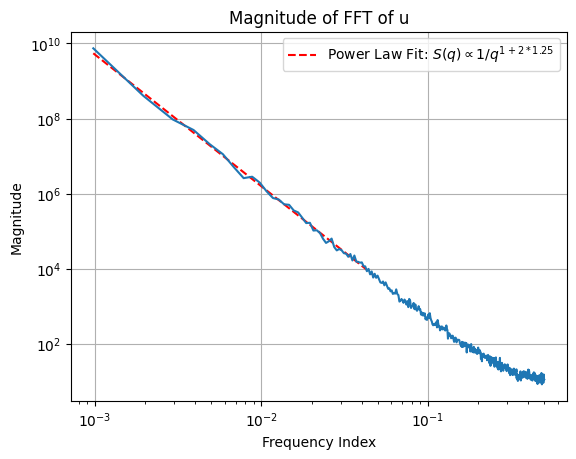

n=18, zeta=1.2546139358827717
Found 50 configurations.
Power law fit for q < 0.05: S(q) = 1.51e-01 * q^{-3.51}
zeta= 1.2535018472455655


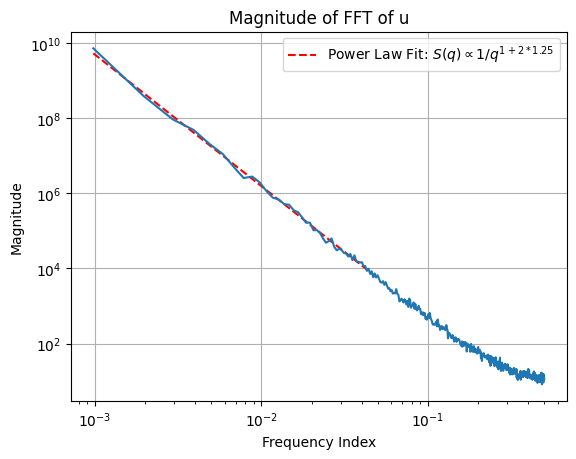

n=19, zeta=1.2535018472455655


In [ ]:
import subprocess
import os

zetavsn=[]

# Primer bucle: de n=2 hasta n=9
for n in range(2, 20):
    # Compilación: se usa f-string para insertar la variable n
    # nvcc -arch=sm_75 alm.cu --extended-lambda -o a.out -DANHN=n
    compile_cmd = ["nvcc", "-arch=sm_75", "alm.cu", "--extended-lambda", "-o", "a.out", f"-DANHN={n}"]
    subprocess.run(compile_cmd, check=True)

    # Segundo bucle: de i=0 hasta i=49
    for i in range(50):
        # Ejecución: ./a.out i
        subprocess.run(["./a.out", str(i)], check=True)

        # Renombrar archivo: mv u.txt u_i.txt
        # Usamos os.rename para que sea una operación nativa y rápida
        if os.path.exists("u.txt"):
            os.rename("u.txt", f"u_{i}.txt")
    zeta = plot_Sq("Sq.txt")
    print(f"n={n}, zeta={zeta}")
    zetavsn.append(zeta)


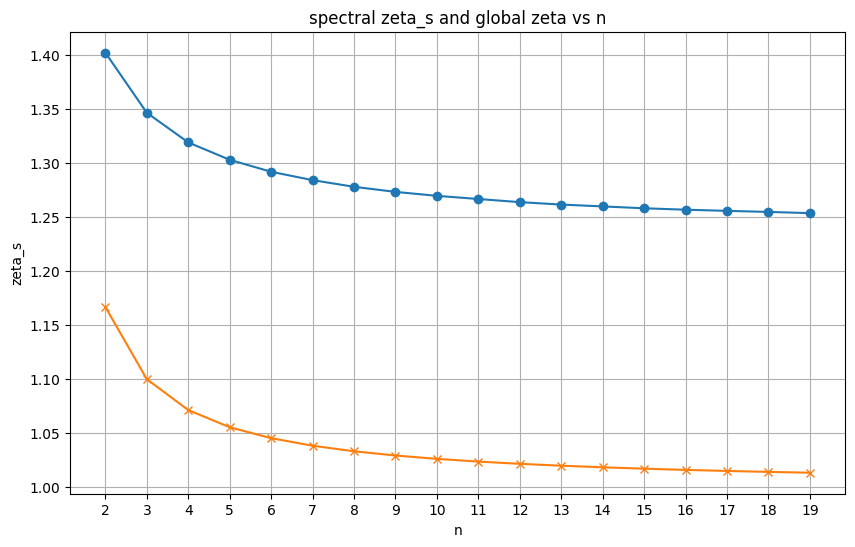

[0.23512073 0.24626179 0.24742579 0.24724347 0.24626424 0.24553976
 0.24450288 0.2437268  0.24316326 0.24274359 0.24191618 0.24141606
 0.24118499 0.24073469 0.24053555 0.2404383  0.24032822 0.23998833]


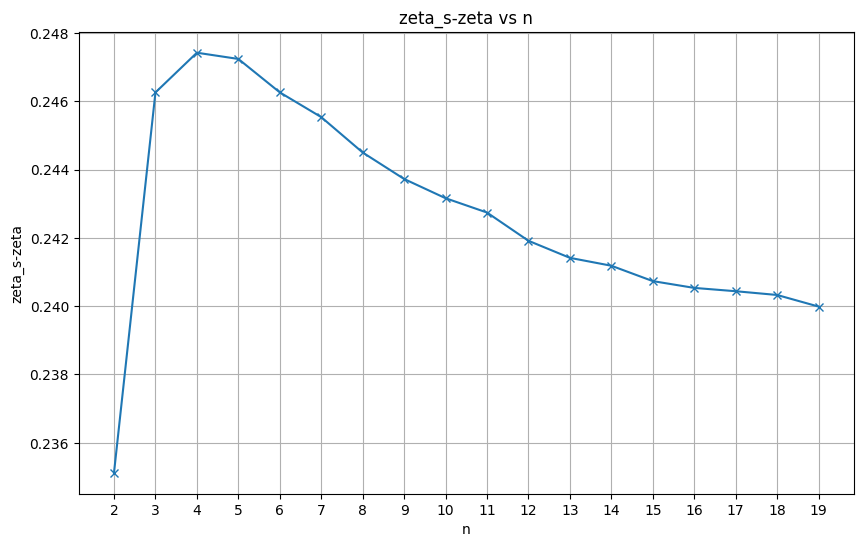

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming zetavsn is already defined and contains the zeta values
# The n values correspond to the indices + 2 (since it starts from n=2)
n_values = np.arange(2, 2 + len(zetavsn))

plt.figure(figsize=(10, 6))
plt.plot(n_values, zetavsn, marker='o', linestyle='-')
plt.plot(n_values, (4*n_values-1)/(4*n_values-2), marker='x', linestyle='-')
plt.xlabel('n')
plt.ylabel('zeta_s')
plt.title('spectral zeta_s and global zeta vs n')
plt.grid(True)
plt.xticks(n_values) # Ensure x-ticks are at integer n values
plt.show()

print(zetavsn-(4*n_values-1)/(4*n_values-2))

plt.figure(figsize=(10, 6))
plt.plot(n_values, zetavsn-(4*n_values-1)/(4*n_values-2), marker='x', linestyle='-')
plt.xlabel('n')
plt.ylabel('zeta_s-zeta')
plt.title('zeta_s-zeta vs n')
plt.grid(True)
plt.xticks(n_values) # Ensure x-ticks are at integer n values
plt.show()


# Finite Size analysis: anomalous roughnening



Found 50 configurations.
Power law fit for q < 0.05: S(q) = 1.24e-02 * q^{-3.89}
zeta= 1.4463301469084082


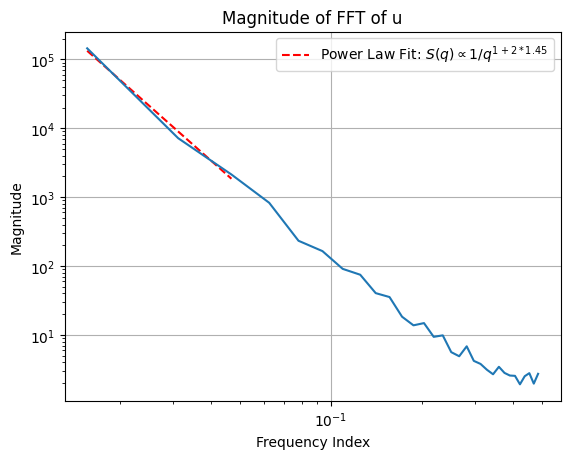

L=64, zeta=1.4463301469084082
Found 50 configurations.
Power law fit for q < 0.05: S(q) = 3.26e-02 * q^{-3.70}
zeta= 1.3504437913280178


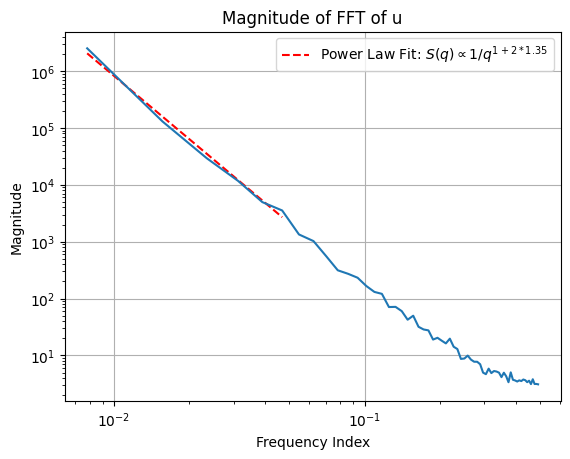

L=128, zeta=1.3504437913280178
Found 50 configurations.
Power law fit for q < 0.05: S(q) = 3.03e-02 * q^{-3.78}
zeta= 1.389317784096149


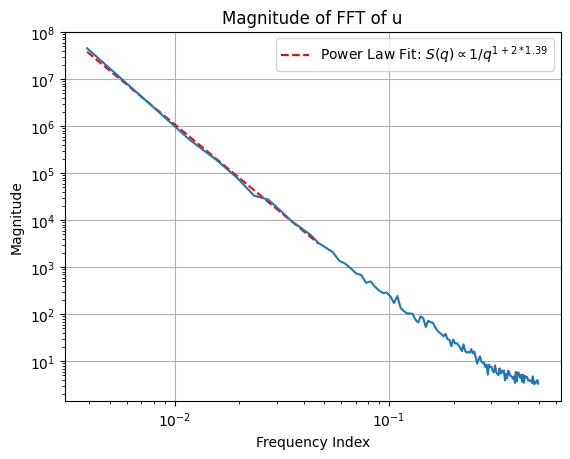

L=256, zeta=1.389317784096149
Found 50 configurations.
Power law fit for q < 0.05: S(q) = 7.87e-02 * q^{-3.65}
zeta= 1.3235326995401004


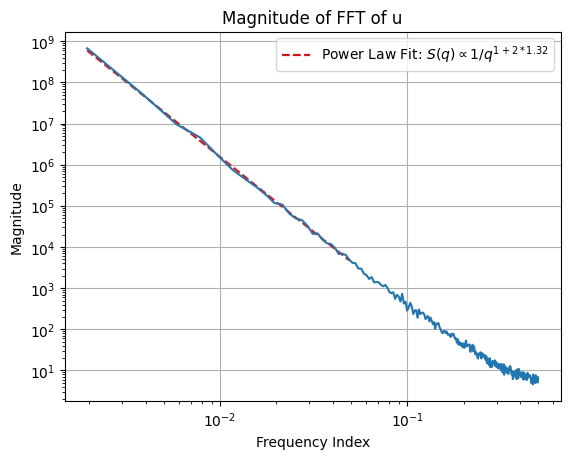

L=512, zeta=1.3235326995401004
Found 50 configurations.
Power law fit for q < 0.05: S(q) = 1.14e-01 * q^{-3.64}
zeta= 1.3188543603483125


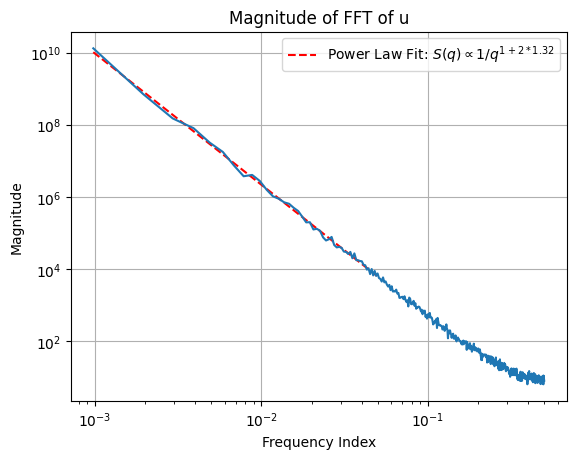

L=1024, zeta=1.3188543603483125
Found 50 configurations.
Power law fit for q < 0.05: S(q) = 4.22e+02 * q^{-2.39}
zeta= 0.696581472128093


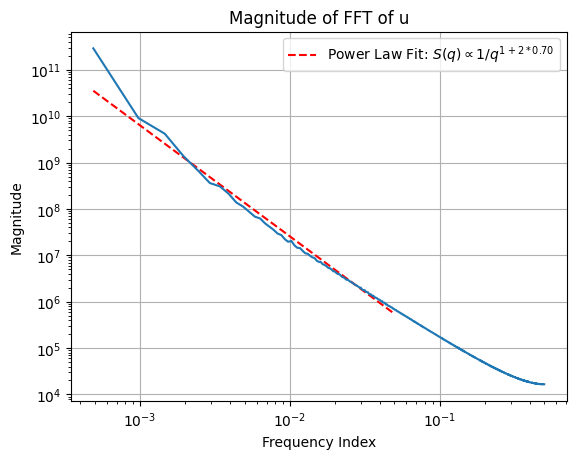

L=2048, zeta=0.696581472128093
Found 50 configurations.
Power law fit for q < 0.05: S(q) = 3.33e+04 * q^{-2.09}
zeta= 0.5467690424408282


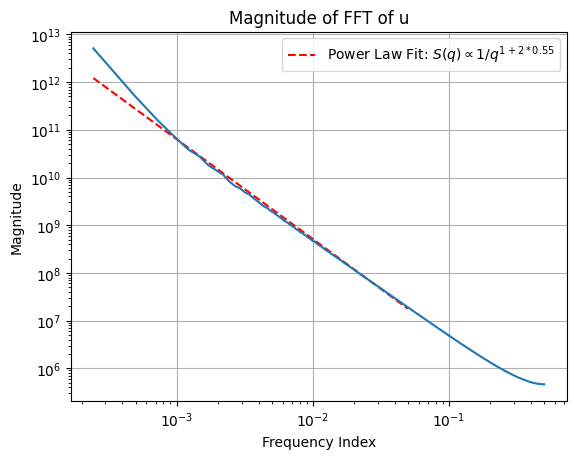

L=4096, zeta=0.5467690424408282


In [ ]:
import subprocess
import os

zetavsL=[]
L_values = [64,128,256,512,1024]

# Primer bucle: de n=2 hasta n=9
for L in L_values:
    # Compilación: se usa f-string para insertar la variable n
    # nvcc -arch=sm_75 alm.cu --extended-lambda -o a.out -DANHN=n
    compile_cmd = ["nvcc", "-arch=sm_75", "alm.cu", "--extended-lambda", "-o", "a.out", f"-DSIZEL={L}",f"-DANHN=4"]
    subprocess.run(compile_cmd, check=True)

    # Segundo bucle: de i=0 hasta i=49
    for i in range(50):
        # Ejecución: ./a.out i
        subprocess.run(["./a.out", str(i)], check=True)

        # Renombrar archivo: mv u.txt u_i.txt
        # Usamos os.rename para que sea una operación nativa y rápida
        if os.path.exists("u.txt"):
            os.rename("u.txt", f"u_{i}.txt")
    zeta = plot_Sq(f"Sq_L_{L}.txt")
    print(f"L={L}, zeta={zeta}")
    zetavsL.append(zeta)


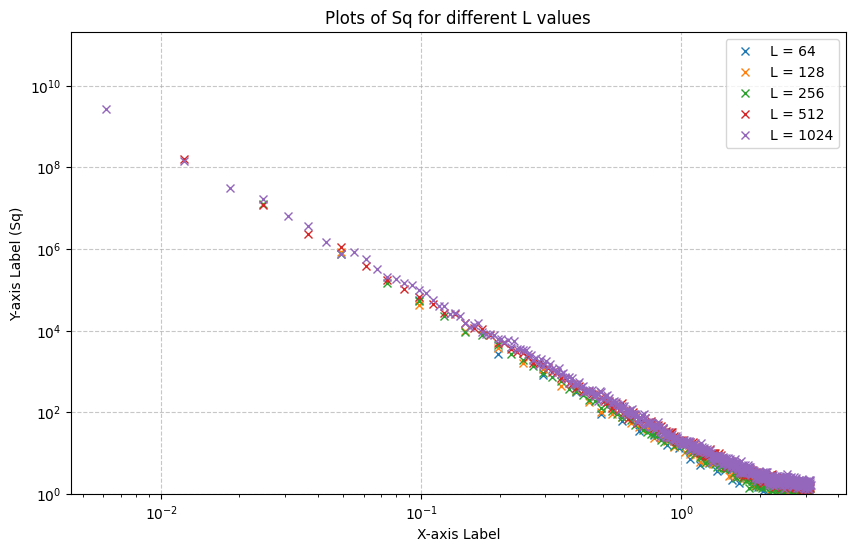

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


L_values = [64,128,256,512,1024]

plt.figure(figsize=(10, 6))

# 2. Loop through each value of L
for L in L_values:
    filename = f"Sq_L_{L}.txt"

    try:
        # Load the data (assuming two columns: x and y)
        data = np.loadtxt(filename)
        y = data[:]
        x = np.arange(len(y))
        yp = y[x<L/2]
        xp = x[x<L/2]*2*np.pi/L
        # Plot each line with a label for the legend
        plt.loglog(xp,yp/L**(0.23), label=f"L = {L}", marker='x',linestyle='')

    except FileNotFoundError:
        print(f"Warning: {filename} not found. Skipping...")

# 3. Add labels, legend, and grid
plt.xlabel("X-axis Label")
plt.ylabel("Y-axis Label (Sq)")
plt.title("Plots of Sq for different L values")
plt.legend()  # Shows the 'L = ...' labels
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(1)

# 4. Show the final result
plt.show()

# Python Code

Check periodicity (sum s): -4.547473508864641e-13
Mean displacement: 4.263256414560601e-14
Check periodicity (sum s): -5.684341886080802e-14
Mean displacement: 1.4210854715202004e-14
Check periodicity (sum s): 2.2168933355715126e-11
Mean displacement: -2.842170943040401e-14
Check periodicity (sum s): 5.684341886080802e-14
Mean displacement: 7.105427357601002e-15
Check periodicity (sum s): -8.958522812463343e-11
Mean displacement: 0.0
Check periodicity (sum s): 1.1368683772161603e-13
Mean displacement: 7.105427357601002e-15
Check periodicity (sum s): -1.1368683772161603e-13
Mean displacement: -1.4210854715202004e-14
Check periodicity (sum s): -1.1368683772161603e-13
Mean displacement: -1.4210854715202004e-14
Check periodicity (sum s): 1.5916157281026244e-12
Mean displacement: -2.842170943040401e-14
Check periodicity (sum s): -2.842170943040401e-14
Mean displacement: 7.105427357601002e-15
Check periodicity (sum s): -1.1368683772161603e-13
Mean displacement: -1.4210854715202004e-14
Check 

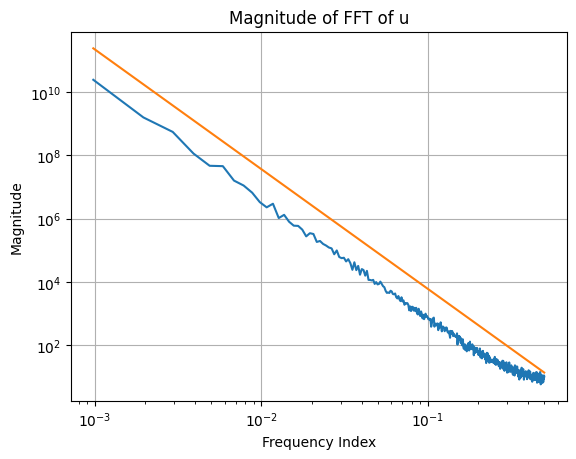

In [ ]:
import numpy as np
from scipy.optimize import brentq


def generate_sample(L,Delta,n,c, seed):
  np.random.seed(seed)
  # -----------------------------
  # Disorder
  # -----------------------------
  f = np.random.normal(0.0, np.sqrt(Delta), size=L)
  f -= f.mean()

  # cumulative disorder force
  F = np.concatenate([[0.0], np.cumsum(f[:-1])])

  # -----------------------------
  # Constitutive inversion
  # -----------------------------
  def slope_from_stress(sigma):
      """
      Solve: c*s + sign(s)*|s|^{2n-1} = sigma
      Unique solution due to convexity
      """
      if c == 0:
          return np.sign(sigma) * abs(sigma)**(1.0/(2*n-1))

      def eq(s):
          return c*s + np.sign(s)*abs(s)**(2*n-1) - sigma

      # bracket safely
      smax = max(1.0, abs(sigma)**(1.0/(2*n-1)) + 1.0)
      return brentq(eq, -smax, smax)

  # vectorized wrapper
  vec_slope = np.vectorize(slope_from_stress)

  # -----------------------------
  # Constraint: zero total slope
  # -----------------------------
  def total_slope(C):
      sigma = F + C
      s = vec_slope(sigma)
      return np.sum(s)

  # find C
  C = brentq(total_slope, -100.0, 100.0)

  # -----------------------------
  # Build solution
  # -----------------------------
  sigma = F + C
  s = vec_slope(sigma)

  u = np.zeros(L)
  u[1:] = np.cumsum(s[:-1])

  # remove arbitrary offset
  u -= u.mean()

  # -----------------------------
  # Diagnostics
  # -----------------------------
  print("Check periodicity (sum s):", np.sum(s))
  print("Mean displacement:", u.mean())

  return u


# -----------------------------
# Parameters
# -----------------------------
L = 1024          # system size
Delta = 1.0       # disorder variance
n = 2             # nonlinear exponent (n >= 1)
c = 0             # harmonic elasticity strength
seed = 12

sq = np.zeros(L)
nsamples=30
for seed in range(nsamples):
  u=generate_sample(L,Delta,n,c, seed)
  sq += np.abs(np.fft.fft(u))**2
  #print(u)

sq /= nsamples
q = np.fft.fftfreq(L, d=1)  # d=1 assumes unit spacing, 2*pi for angular frequency
#q = np.fft.fftshift(q) # Shift zero frequency to the center

qpos = q[q>0]
sqpos = sq[q>0]

plt.loglog(qpos, sqpos)
plt.loglog(qpos, 1./qpos**(1+2*1.39))
plt.xlabel('Frequency Index')
plt.ylabel('Magnitude')
plt.title('Magnitude of FFT of u')
plt.grid(True)
plt.show()


In [ ]:
print(u)

[-60.5061124  -58.3452135  -56.21619968 ... -66.78224891 -64.65040654
 -62.6453791 ]


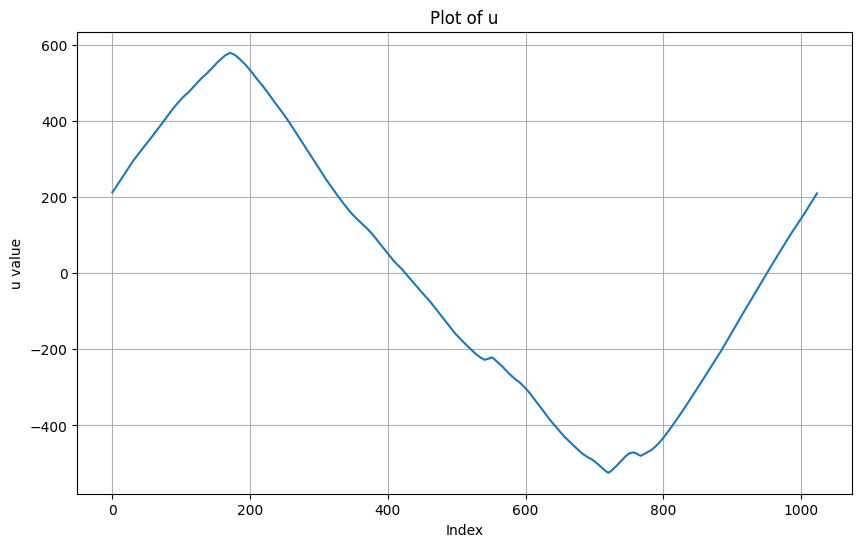

In [ ]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(u)
plt.xlabel('Index')
plt.ylabel('u value')
plt.title('Plot of u')
plt.grid(True)
plt.show()